In [16]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *

In [17]:
risk_free_rate = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\DGS3MO_daily.csv', index_col=0, header=0)
risk_free_rate = np.array(risk_free_rate)
Price = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\price_com_mat.csv', index_col=0, header=0)
Price = np.mat(Price)
#print risk_free_rate
#print len(risk_free_rate)
#print Price
#print len(Price)

In [29]:
#Calculate mu and V
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
def adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay):  
    h = horizon # 
    P = Price # the Price matrix, each row refer to a date and each column refers to an asset
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = sample_frequency #num
    n_s = number_of_samples #num
    r_d = rate_of_decay #num

    s_d = t_d-1-np.arange(n_s+1)*s_f #reverse chronological
    s_d = s_d[::-1] #chronological    
    #sample dates, a row vector

    S_P = P[s_d,:] #Sample Prices, a matrix

    S_C_R = np.log(S_P[1:,:]/S_P[:-1,:]) #Sample Compound Returns, a matrix
    #now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(1,n_s+1)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    #print "wt", wt
    mean_c_r = S_C_R.T*wt  #mean vector of compound returns
    Cov_C_R = (S_C_R.T*np.diag(w)*S_C_R)-mean_c_r*np.transpose([mean_c_r])
    #covariance matrix of compound returns
    #print "mean_c_r:", mean_c_r
    #print "Cov_C_R", Cov_C_R
    adapted_mean_c_r = mean_c_r*(float(h)/float(s_f))
    #adapting mean vector to reflect length of holding period
    
    Adapted_Cov_C_R = Cov_C_R*(float(h)/float(s_f))
    #adapting covariance matrix to length of holding period
    #print "adapted_mean_c_r:",adapted_mean_c_r
    #print "Adapted_Cov_C_R:",Adapted_Cov_C_R
    muu = np.exp(adapted_mean_c_r + 0.5*np.mat(np.diag(Adapted_Cov_C_R)).T)
    #print muu
    mu = muu - 1
    #resulting mean vector of ARITHMETIC returns
    
    V = np.multiply((muu*np.transpose([muu.T])),(np.exp(Adapted_Cov_C_R)-1))
    #resulting covariance matrix of ARITHMETIC returns
    return mu,V

In [38]:
def markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost):
    n = len(mu)
    U = np.linalg.cholesky(V)
    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
    objective = Maximize(mu0*x0+mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.02,
                   #0.05<=x,
                   #x<=0.2,
                   #x[1]+x[4]<=x[5]+x[6]+x[8],
                   #sum_smallest(x,4)>=-1.25
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()  # Returns the optimal value.
    #print "status:", prob.status
    #print "optimal value", prob.value
    #print "optimal var", x.value, y.value
    return x0.value,x.value

In [39]:
def rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    #print "number of assets:",n
    #print "sum:",sum(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [(n+1)*z <= benchmark_x0+sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

In [42]:
a=[]
a.append(12.3)
a

[12.3]

In [43]:
###############  BACKTEST  ###############
n = np.size(Price)/len(Price) # n=number of risky assets
e = np.ones([n,1])

###############
#### PARAMETERS
#### (the following choices of parameters can easily be changed)

horizon = 5 # rebalance daily
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
start = 120 # the day on which you are first given a portfolio to rebalance
number_rebalances = 100 # the number of times the portfolio will be rebalanced 
number_of_samples = 20 # how many samples are to be used 
                      # in computing return avereages and covariances
sample_frequency = 5 # 1 = daily, 2 = , etc.
r_w_f_o_y_e = 0.4 # "relative weight for one year earlier" 
                 # -- a value .4 means that for the (exponential) weights 
                 # used in computing return averages and covariances, 
                 # the weight assigned to the time period one year ago
                 # should be .4 times the weight assigned 
                 # to the most recent period.     
allowable_risk = 1
    # This is the level of risk relative to the benchmark portfolio,
    #   where risk is measured as standard deviation of portfolio returns.
    # Choosing this value to equal 1 means exactly the same amount of risk is allowed,
    # whereas choosing 2 means twice as much risk is allowed as the benchmark, and so on.
trans_cost = 0.005  # transaction cost
wealth = 10000 # initial wealth measured in dollars, including money invested in assets
               # (one dollar invested in an asset is considered as one dollar of wealth,
               #  even though in liquidating the asset, transaction costs would be paid)   
x0 = 0.3 # proportion of wealth in bank initially
x = (0.7/n)*e # proportions in risky assets initially

# Assume the benchmark portfolio is initally equal-weighted, with 1/(n+1) being the 
# proportion of wealth invested in each asset and in the bank.
#### END OF PARAMETERS
######################
#rate_of_decay = 0
rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
initial_wealth = wealth
benchmark_wealth = wealth
portfolio_value = [wealth]
benchmark_value = [wealth]
rebalance_dates = start + horizon*np.arange(number_rebalances)

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
    # It is more natural to rebalance the benchmark portfolio later #

    mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
    #[mu,V] = stats(Price,trade_date,sample_frequency,number_of_samples,rate_of_decay)
    mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
    
    #benchmark_risk = sqrt(quad_form(e, V))/n # there are n assets in the portfolio
    benchmark_risk = sqrt(quad_form(e,V))/(n+1)  # there are n+1 financial instruments
                                                        # including the bank
    sigma = allowable_risk*benchmark_risk
    
    xx0 = x0
    xx = x
    #print "mu", mu.T
    x0,x =  markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost)
    #print "x0:", x0
    #print "x:", x.T
    wealth = wealth*(x0+sum(x))
        # This is the same thing as updating your wealth by subtracting
        # all transaction costs from the rebalancing.  Indeed, in rebalancing,
        # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  
        
    total = x0+sum(x)
    x0 = x0/total
    x = x/total
        # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)
    
    ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######
    
    returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
        # vector of actual returns for risky assets (this is a row vector)
    
    multiplier = 1+mu0*x0+returns*x
    wealth = multiplier*wealth
            # by leaving off the semicolon, you can watch how wealth changes as the program runs

    if(wealth<=0):
        break   # stops the program if bankruptcy occurs
                # Not needed for benchmark portfolio (because it is long only)
    
    x0 = (1+mu0)*x0/multiplier
    x = np.multiply(x,np.transpose(1+returns))/multiplier
    # these are the proportions of current wealth invested in assets
    # Now its time to rebalance the benchmark portfolio and pay transaction costs

    
    benchmark_x0 = (1+mu0)/(n+1)
    benchmark_x = (1+returns)/(n+1)
    # This gives how the equal-weighted portfolio has changed during the time period.
    # The initial unit of wealth has become  benchmark_x0 + sum(benchmark_x).
    # This new level of wealth needs to be distributed equally among the assets and bank.
    # The optimal amount z to put into each one is determined by the following function,
    # which finds the value z so as to minimize transaction costs
    #print i,"returns:", returns
    #print "benchmark_x:",benchmark_x
    
    z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
    benchmark_wealth = benchmark_wealth*(n+1)*z
    #print "z:",z

    # Until the end of the next time period, 
    # think of the benchmark portfolio as having been rebalanced
    # with wealth divided equally, that is, the portion of wealth invested in
    # each asset and the bank is 1/(n+1).
    
    portfolio_value.append(wealth)
    benchmark_value.append(benchmark_wealth)

In [44]:
print "your final bank account:", x0 
print "your final risky portfolio:", x 
print "your final wealth:", wealth 
print "benchmark final wealth:", benchmark_wealth 
print "your annualized rate of return:", float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "benchmark annualized rate of return:", benchmark_annual_return

your final bank account: [[ 0.11075301]]
your final risky portfolio: [[ 0.01220232]
 [ 0.05209227]
 [ 0.01225162]
 [ 0.01199279]
 [ 0.0121829 ]
 [ 0.01154199]
 [ 0.01216501]
 [ 0.01180668]
 [ 0.01216526]
 [ 0.01221578]
 [ 0.05436993]
 [ 0.01205291]
 [ 0.01177019]
 [ 0.01230104]
 [ 0.05240352]
 [ 0.05151806]
 [ 0.05362008]
 [ 0.01209213]
 [ 0.05337701]
 [ 0.05232225]
 [ 0.05300042]
 [ 0.05197707]
 [ 0.01186339]
 [ 0.05300943]
 [ 0.05299319]
 [ 0.01216725]
 [ 0.05273402]
 [ 0.05167783]
 [ 0.0115512 ]
 [ 0.01182946]]
your final wealth: [[ 11685.86198995]]
benchmark final wealth: 12636.7995814
your annualized rate of return: 0.0826971261723
benchmark annualized rate of return: 0.126769077239


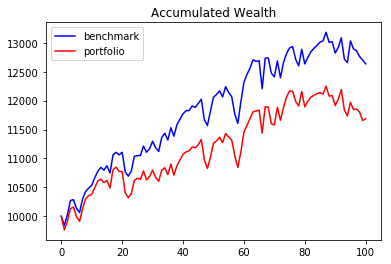

In [61]:
plt.figure(1)
plt.title("Accumulated Wealth")
plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="portfolio")
plt.legend()
plt.show()